In [1]:
import numpy as np
import brian2 as b2
import brian2tools as b2t
from brian2.units import Hz, second, ms, volt, mV

from make_test_samples import make_test_samples

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

# Supress brian info messages regarding integration method
b2.BrianLogger.suppress_name('method_choice')

Using the code in make_test samples, generate two test samples by making two prototype collections of poisson generated spike trains
with the given rate, duration and number of neurons.  
Then generate a set of randomly shifted versions from each prototype according
to the specified maximal temporal shift of each spike, and the desired set sizes (from each prototype).  
These shifted versions are then shuffled and combined into a single array,
another labels array is created where each elements corresponds to one of the shifted versions, and denotes its originating prototype.

In [19]:
n = 500
test_sample_params = dict(
    rate=5,
    duration_sec=1,
    num_neur=n,
    shift_size=5,
    set1_size=500,
    set2_size=500)
samples = make_test_samples(**test_sample_params)

WARNING    "rate" is an internal variable of group "neurongroup_2", but also exists in the run namespace with the value 5. * hertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "dt" is an internal variable of group "neurongroup_2", but also exists in the run namespace with the value 1. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Trying a simple brian connectivity model with 10 neurons driving a single neuron

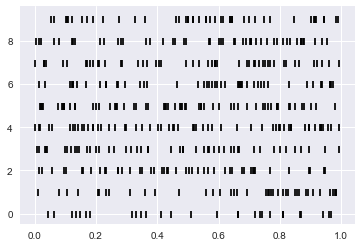

In [5]:
b2.start_scope()
rate = 50 * Hz
duration = 1 * second
driving = b2.NeuronGroup(n, "rate: Hz", threshold='rand()<rate*dt')
driving.rate = rate

target = b2.NeuronGroup(1, 'v: 1',threshold='v>1', reset='v=0')

S = b2.Synapses(driving, target, on_pre="v+=0.1")
S.connect(i=list(range(n)), j=0)

d_spikes = b2.SpikeMonitor(driving, record=True)
t_spikes = b2.SpikeMonitor(target, record=True)
M = b2.StateMonitor(target, 'v', record=True)

b2.run(duration)
for i, times in d_spikes.spike_trains().items():
    plt.scatter(times, [i]*len(times), marker='|', color='black')

Attempting to load existing sample

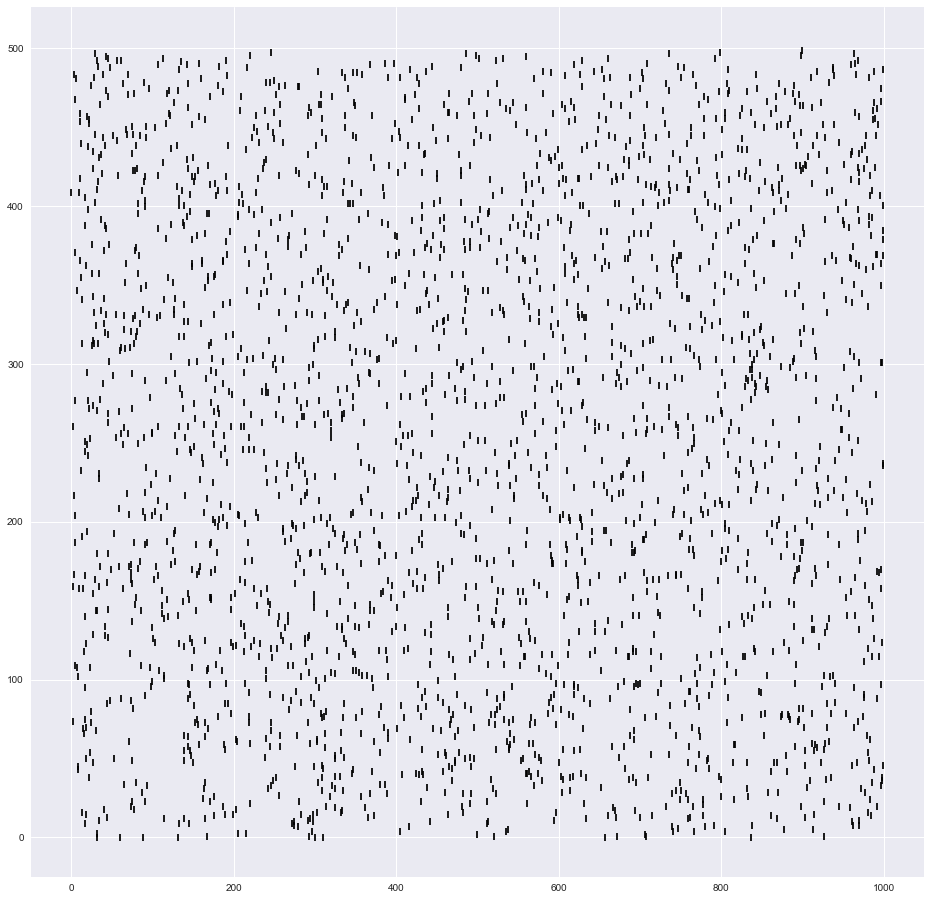

In [21]:
sampnum = 5
sample = samples['data'][sampnum]

def flatten_sample(sample):
    inds = []
    times = []
    for i, neuron in enumerate(sample):
        inds.extend([i] * neuron.shape[0])
        times.extend(neuron)
    return np.array([inds, times])

flat_sample = flatten_sample(sample)

b2.start_scope()
driving = b2.SpikeGeneratorGroup(n, flat_sample[0], flat_sample[1]*ms, dt=1*ms)
d_spikes = b2.SpikeMonitor(driving, record=True)
b2.run(1*second)
plt.figure(figsize=(16,16))
for i, times in d_spikes.spike_trains().items():
    plt.scatter(times / ms, [i]*len(times),marker='|', color='black')

Adding neural weights to the model

In [28]:
sampnum = 5
sample = samples['data'][sampnum]
flat_sample = flatten_sample(sample)

act_str = 0.1

b2.start_scope()
driving = b2.SpikeGeneratorGroup(n, flat_sample[0], flat_sample[1]*ms)

eqs = '''
v: 1
'''
target = b2.NeuronGroup(1, eqs,threshold='v>1', reset='v=0')

S = b2.Synapses(driving, target, 'w: 1', on_pre="v+=w*act_str", namespace={'act_str': act_str})
S.connect(i=list(range(n)), j=0)
S.w = np.random.rand(n)

d_spikes = b2.SpikeMonitor(driving, record=True)
t_spikes = b2.SpikeMonitor(target, record=True)
M = b2.StateMonitor(target, 'v', record=True)
b2.run(1*second)


Testing decay model

INFO       No numerical integration method specified for group 'neurongroup', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]


Text(0,0.5,'mV')

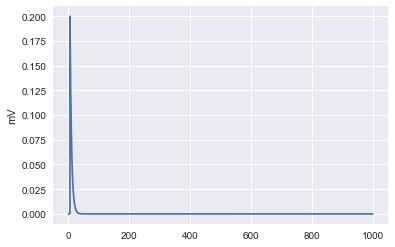

In [9]:
b2.start_scope()

duration = 1 * second
tau = 5 * ms

eqs = '''
dv/dt = -v / tau: volt
'''

driving = b2.SpikeGeneratorGroup(1, [0], [5*ms])
target = b2.NeuronGroup(1, eqs)

S = b2.Synapses(driving, target, on_pre="v+=0.2*mV")
S.connect(i=0, j=0)

M = b2.StateMonitor(target, 'v', record=True)
b2.run(1*second)

plt.plot(M.t /ms, M.v[0] / mV)
plt.ylabel('mV')

Combining convergent input with weights and exponential decay

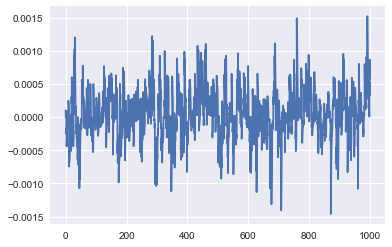

In [38]:
b2.start_scope()

tau = 2 * ms
duration = 1 * second
spike_dv = 0.2 * mV
threshold = 1 * mV

weights = np.random.normal(0, 1e-3, n)

## UNUSED VARS FOR FUTURE USE
baseline_v = -70 * mV

samp_num = 5
sample = samples['data'][sampnum]
sample = flatten_sample(sample)

driving = b2.SpikeGeneratorGroup(n, sample[0], sample[1]*ms)

eqs = '''
dv/dt = -v / tau: volt
'''
target = b2.NeuronGroup(1, eqs, threshold='v>threshold', reset='v=0*mV')

S = b2.Synapses(driving, target, 'w: 1', on_pre="v+=w*spike_dv")
S.connect(i=list(range(n)), j=0)
S.w = weights

d_spikes = b2.SpikeMonitor(driving, record=True)
t_spikes = b2.SpikeMonitor(target, record=True)
M = b2.StateMonitor(target, 'v', record=True)

b2.run(1*second)

plt.plot(M.t / ms, M.v[0]/ mV)
plt.plot(t_spikes.spike_trains()[0] / ms, [0] * t_spikes.spike_trains()[0].shape[0], '.k')

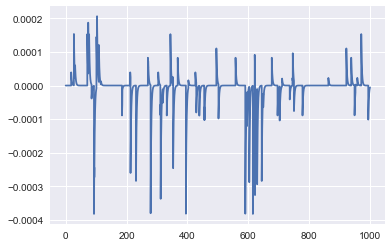

In [11]:
plt.plot(M.t / ms, M.v[0]/ mV)
vmax_ind = M.v[0].argmax()
t_vmax = M.t[vmax_ind]
plt.plot(t_spikes.spike_trains()[0] / ms, [0] * t_spikes.spike_trains()[0].shape[0], '.k')

In [31]:
class Tempotron():
    def __init__(self, num_neurons, tau, spike_dv, threshold, baseline_v=0, duration=1):
        self.tau = tau * ms
        self.spike_dv = spike_dv * mV
        self.threshold = threshold * mV
        self.baseline_v = baseline_v * mV
        self.num_neurons = num_neurons
        self.duration = 1 * second
        
        self.weights = np.random.normal(0, 1e-3, num_neurons)
    
        self.eqs =  '''
        dv/dt = -v / tau: volt
        '''
        
        
        
    def classify(self, sample):
        '''
        sample is a 2 row array containing the neuron indices and their firing times
        '''
        b2.start_scope()
        threshold = self.threshold
        baseline_v = self.baseline_v
        spike_dv = self.spike_dv
        target =  b2.NeuronGroup(1, self.eqs, threshold='v>threshold', reset='v=baseline_v')
        driving = b2.SpikeGeneratorGroup(self.num_neurons, sample[0], sample[1]*ms)
        S = b2.Synapses(driving, target, 'w: 1', on_pre="v+=w*spike_dv")
        S.connect(i=list(range(self.num_neurons)), j=0)
        S.w = self.weights
        
        spikes = b2.SpikeMonitor(target, record=True)
        voltage = b2.StateMonitor(target, 'v', record=True)
        
        b2.run(self.duration)
        vmax_ind = voltage.v[0].argmax()
        t_vmax = voltage.t[vmax_ind]
        decision = len(spikes.spike_trains()[0]) != 0
        return decision, t_vmax
    
    def train(self, sample, label, learning_rate=1e-4):
        decision, t_vmax = self.classify(sample)
        match = (decision == label)
        if not match:
            temp_neur = b2.NeuronGroup(self.num_neurons, self.eqs)
            driving = b2.SpikeGeneratorGroup(self.num_neurons, sample[0], sample[1]*ms)
            spike_dv = self.spike_dv
#             S = b2.Synapses(driving, temp_neur, on_pre="v+=spike_dv")
            S = b2.Synapses(driving, temp_neur, on_pre="v+=spike_dv")
            S.connect(i=list(range(self.num_neurons)), j=list(range(self.num_neurons)))
            
            voltages = b2.StateMonitor(temp_neur, 'v', record=True)
            b2.run(t_vmax)
            v_end = voltages.v[:, -1] / mV
            weight_upd = learning_rate * (label - decision) * v_end # Should be label - decision methinks
#             print(f'label is {label}, decision is {decision}')
#             print(f'weight update: {weight_upd}')
            self.weights += weight_upd
            
    def plot_response(self, sample):
        b2.start_scope()
        threshold = self.threshold
        baseline_v = self.baseline_v
        spike_dv = self.spike_dv
        target =  b2.NeuronGroup(1, self.eqs, threshold='v>threshold', reset='v=baseline_v')
        driving = b2.SpikeGeneratorGroup(self.num_neurons, sample[0], sample[1]*ms)
#         S = b2.Synapses(driving, target, 'w: 1', on_pre="v+=w*spike_dv")
        S = b2.Synapses(driving, target, 'w: 1', on_pre="v+=w")
        S.connect(i=list(range(self.num_neurons)), j=0)
        S.w = self.weights
        
        spikes = b2.SpikeMonitor(target, record=True)
        voltage = b2.StateMonitor(target, 'v', record=True)
        
        b2.run(self.duration)
        plt.plot(voltage.t /ms, voltage.v[0] / mV)
        plt.hlines(threshold/mV, 0, 1000)
            
        

In [39]:
samp_num = 5
sample = samples['data'][samp_num]
sample = flatten_sample(sample)
label = samples['labels'][samp_num]

T = Tempotron(
    num_neurons=n,
    tau=2,
    spike_dv=0.2,
    threshold=1e-4,)
res,_ = T.classify(sample)
print(res)
print(res == label)
# plt.plot(v[0])
# print(res, label)
# match, new_w = T.train(sample, label)
T.train(sample, label)


True
False


Pre training assesment

In [40]:
import time
# n_samps = samples['data'].shape[0]
n_samps = 100
res = []
T = Tempotron(
    num_neurons=n,
    tau=2,
    spike_dv=0.2,
    threshold=1e-4,)
times = []
w_pre = T.weights.copy()
for i in range(n_samps):
    curr_t = time.time()
    print(f'\r{i}', end='')
    sample = flatten_sample(samples['data'][i])
    res.append(T.classify(sample)[0])
    times.append(time.time() - curr_t)
print(f"\nAccuracy is: {np.isclose(res, samples['labels'][:n_samps]).mean():.2%}")
print(f"Each iteration took {np.mean(times):.3f} ± {np.std(times, ddof=0):.3f} seconds for a total of {time.strftime('%M:%S',time.gmtime(np.sum(times)))} minutes")

99
Accuracy is: 51.00%
Each iteration took 0.885 ± 0.050 seconds for a total of 01:28 minutes


Attempting to train the model

In [41]:
times_train = []
reps = 5
for j in range(reps):
    for i in range(n_samps):
        curr_t = time.time()
        print(f'\rRep_{j}: {i}', end='')
        sample = flatten_sample(samples['data'][i])
        label = samples['labels'][samp_num]
        T.train(sample, label, learning_rate=1e-3)
        times_train.append(time.time() - curr_t)
print(f"\nEach iteration took {np.mean(times_train):.3f} ± {np.std(times_train, ddof=0):.3f} seconds for a total of {time.strftime('%M:%S',time.gmtime(np.sum(times_train)))} minutes")

Rep_4: 99
Each iteration took 1.255 ± 0.424 seconds for a total of 10:27 minutes


Post training assesment

In [42]:
res_post = []
times_post = []
for i in range(n_samps):
    curr_t = time.time()
    print(f'\r{i}', end='')
    sample = flatten_sample(samples['data'][i])
    res_post.append(T.classify(sample)[0])
    times_post.append(time.time() - curr_t)
print(f"\nAccuracy is: {np.isclose(res_post, samples['labels'][:n_samps]).mean():.2%}")
print(f"Each iteration took {np.mean(times_post):.3f} ± {np.std(times_post, ddof=0):.3f} seconds for a total of {time.strftime('%M:%S',time.gmtime(np.sum(times_post)))} minutes")
w_post = T.weights.copy()

99
Accuracy is: 32.00%
Each iteration took 0.842 ± 0.012 seconds for a total of 01:24 minutes


In [43]:
w_post - w_pre

array([ -6.97237369e-04,  -4.04354648e-04,  -2.84145861e-04,
        -2.99668059e-04,  -5.17029165e-04,  -1.04545912e-03,
        -4.82031035e-04,  -1.99219410e-04,  -6.47838502e-04,
        -3.10910744e-04,  -1.86064321e-04,  -1.55734561e-04,
        -1.07024775e-03,  -4.32225525e-04,  -6.11182760e-04,
        -6.37841291e-04,  -4.33498367e-04,  -4.86870878e-04,
        -3.65913528e-04,  -9.78971365e-04,  -9.83986989e-04,
        -2.98958248e-04,  -7.03710454e-05,  -2.48822689e-04,
        -1.05540036e-04,  -6.05910240e-08,  -3.25758489e-04,
        -1.69219561e-04,  -2.28936704e-04,  -5.08147027e-04,
        -7.45254925e-04,  -4.64220821e-04,  -1.54486532e-04,
        -1.00560533e-03,  -4.85891899e-04,  -4.06233046e-04,
        -4.41630003e-04,  -3.74114318e-04,  -5.38537098e-04,
        -5.30683065e-04,  -1.49110223e-04,  -6.19214282e-04,
        -1.17035540e-03,  -4.02462759e-04,  -7.39690286e-04,
        -2.48341177e-04,  -7.39641063e-04,  -4.36143174e-06,
        -1.50009342e-03,

In [44]:
w_post

array([ -9.27917856e-04,  -1.32487351e-03,  -1.74189569e-03,
         9.83517441e-04,  -8.07314306e-04,  -3.96989476e-04,
        -1.05227405e-03,   8.79411523e-04,  -1.51361234e-03,
        -7.79455910e-04,  -1.02488633e-03,   1.23656223e-04,
        -1.35056547e-03,  -3.18254304e-04,  -4.79646177e-05,
         4.17954233e-04,  -2.26403622e-03,   2.95304590e-04,
        -1.48335381e-03,   3.78374523e-04,   3.20823205e-04,
        -5.79288151e-04,  -2.63558538e-03,  -2.39198542e-03,
         3.39715030e-04,   4.92464820e-04,  -1.77825444e-03,
        -8.47625164e-04,   3.08230986e-04,   8.43504211e-04,
        -5.90689590e-04,   8.60552433e-04,  -6.47164819e-04,
        -4.85488555e-04,  -1.73505517e-03,  -7.49169930e-04,
        -1.13692558e-03,  -5.50040692e-04,  -9.61233730e-04,
        -2.46009557e-03,   3.49196441e-06,  -2.09789918e-04,
         4.96365775e-05,  -2.05020535e-03,  -6.46818084e-04,
        -3.71902212e-04,   3.19902011e-04,  -6.38709826e-04,
        -1.79003419e-04,